# CIFAR-100 Dataset

## Overview
This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
Here is the list of classes in the CIFAR-100:

## Superclass and Classes

- **Aquatic Mammals:** Beaver, Dolphin, Otter, Seal, Whale  
- **Fish:** Aquarium Fish, Flatfish, Ray, Shark, Trout  
- **Flowers:** Orchids, Poppies, Roses, Sunflowers, Tulips  
- **Food Containers:** Bottles, Bowls, Cans, Cups, Plates  
- **Fruit & Vegetables:** Apples, Mushrooms, Oranges, Pears, Sweet Peppers  
- **Household Electrical Devices:** Clock, Keyboard, Lamp, Telephone, TV  
- **Household Furniture:** Bed, Chair, Couch, Table, Wardrobe  
- **Insects:** Bee, Beetle, Butterfly, Caterpillar, Cockroach  
- **Large Carnivores:** Bear, Leopard, Lion, Tiger, Wolf  
- **Man-Made Outdoor Things:** Bridge, Castle, House, Road, Skyscraper  
- **Natural Outdoor Scenes:** Cloud, Forest, Mountain, Plain, Sea  
- **Omnivores & Herbivores:** Camel, Cattle, Chimpanzee, Elephant, Kangaroo  
- **Medium Mammals:** Fox, Porcupine, Possum, Raccoon, Skunk  
- **Non-Insect Invertebrates:** Crab, Lobster, Snail, Spider, Worm  
- **People:** Baby, Boy, Girl, Man, Woman  
- **Reptiles:** Crocodile, Dinosaur, Lizard, Snake, Turtle  
- **Small Mammals:** Hamster, Mouse, Rabbit, Shrew, Squirrel  
- **Trees:** Maple, Oak, Palm, Pine, Willow  
- **Vehicles 1:** Bicycle, Bus, Motorcycle, Pickup Truck, Train  
- **Vehicles 2:** Lawn-Mower, Rocket, Streetcar, Tank, Tractor

Source:
https://www.cs.toronto.edu/%7Ekriz/cifar.html


In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
import wget
import tarfile

from functools import partial
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
RANDOM_SEED = 42
IMG_HEIGHT = 32
IMG_WIDTH = 32
BATCH_SIZE = 32

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [4]:
url_file = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
file_name = wget.download(url_file)

In [6]:
extract_path = "./"                   

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"Extracted {file_name} to {extract_path}")

Extracted cifar-100-python.tar.gz to ./


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
metadata_path = 'cifar-100-python/meta'
metadata = unpickle(metadata_path)

In [7]:
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))
subclass_dict = dict(list(enumerate(metadata[b'fine_label_names'])))

In [8]:
# Download Dataset from Kaggle or from the official website
data_train_path = "cifar-100-python/train"
data_test_path = "cifar-100-python/test"

data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)

data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'fine_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'fine_labels'])

In [9]:
train_ids, val_ids, train_labels, val_labels = train_test_split(np.arange(0, 50000), label_train, test_size=0.2, stratify=label_train, random_state=RANDOM_SEED)

In [10]:
data_train = tf.convert_to_tensor(data_train)
label_train = tf.convert_to_tensor(label_train)
data_test = tf.convert_to_tensor(data_test)
label_test = tf.convert_to_tensor(label_test)

In [11]:
@tf.function
def load_img(idx, with_scaling=True):
    image = tf.gather(data_train, idx)
    image = tf.transpose(tf.reshape(image, (3, 32, 32)))
    image = tf.image.convert_image_dtype(image, tf.float16)
    
    label = tf.gather(label_train, idx)
    label = tf.cast(label, tf.float16)
    label = tf.reshape(label, [])
    
    return image, label

In [12]:
@tf.function
def apply_data_augmentation(image, label, scale_mode='0_1',  augmentation_type=None):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    if augmentation_type == 'randaugment':
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        
        max_shift = 4
        image = tf.image.resize_with_crop_or_pad(image, IMG_HEIGHT + max_shift, IMG_WIDTH + max_shift)
        image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    if scale_mode == '0_1':
        image = tf.cast(image, tf.float32)
        image = tf.clip_by_value(image, 0.0, 1.0)
    else:
        image = tf.clip_by_value(image * 255, 0, 255)
        image = tf.round(image)
        image = tf.cast(image, tf.uint8)

    return image, label

In [12]:
train_dataset_ids = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset = train_dataset_ids.map(lambda id: load_img(id),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_dataset_unscaled = train_dataset_ids.map(lambda id: load_img(id),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [13]:
val_dataset_ids = tf.data.Dataset.from_tensor_slices(val_ids)
val_dataset = val_dataset_ids.map(lambda id: load_img(id), 
                      num_parallel_calls=tf.data.AUTOTUNE)
val_dataset_unscaled = val_dataset_ids.map(lambda id: load_img(id), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
def configure_performance(ds, is_train_ds=True, scale_mode="0_1", augmentation_type=None):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.map(lambda img, label: apply_data_augmentation(img, label, scale_mode=scale_mode, augmentation_type=augmentation_type), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [15]:
train_dataset = configure_performance(train_dataset, is_train_ds=True, scale_mode="0_1", augmentation_type=None)
val_dataset = configure_performance(val_dataset, is_train_ds=False)

In [16]:
train_dataset_unscaled = configure_performance(train_dataset_unscaled, is_train_ds=True, scale_mode="0_255", augmentation_type=None)
val_dataset_unscaled = configure_performance(val_dataset_unscaled, is_train_ds=False)

In [17]:
image_batch, labels_batch = next(iter(train_dataset))

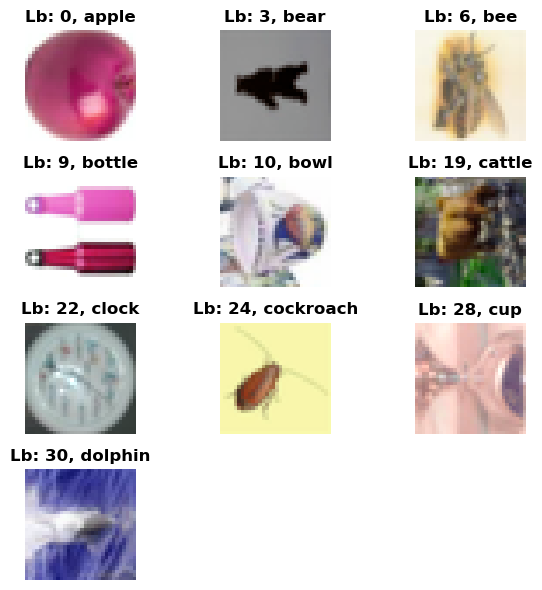

In [18]:
plt.figure(figsize=(6, 6))

for idx, label in enumerate(np.unique(labels_batch.numpy().astype(int).tolist())[:10]):
  ax = plt.subplot(4, 3, idx + 1)
  label_idx = tf.argmax(labels_batch.numpy() == label).numpy()
  plt.imshow(image_batch[label_idx])
  plt.title(f"Lb: {label}, {[value.decode('utf-8') for objct, value in subclass_dict.items() if objct ==label][0]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()


# Building a CNN with Sequential API

In [19]:
import math

In [20]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay 
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule for custom scheduling

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_target, warmup_steps, decay_steps, alpha=0.0):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_target = warmup_target
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha

    def __call__(self, step):
        warmup_lr = self.initial_learning_rate + (self.warmup_target - self.initial_learning_rate) * (step / self.warmup_steps)
        
        step_cosine = step - self.warmup_steps
        decay_steps_adjusted = self.decay_steps - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(tf.constant(math.pi) * step_cosine / decay_steps_adjusted))
        decayed_lr = (1 - self.alpha) * cosine_decay + self.alpha
        decayed_lr = self.warmup_target * decayed_lr

        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )

In [21]:
# Nice Documentation: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
regularizer = tf.keras.regularizers.l2(1e-3)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(100, activation='softmax', kernel_regularizer=regularizer)
])

In [29]:
lr_schedule = WarmupCosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=5000,    
    decay_steps=120000,  
    alpha=0.0
)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
)

Epoch 1/100
1250/1250 [==============================] - 40s 28ms/step - loss: 5.3375 - accuracy: 0.0528 - val_loss: 4.6188 - val_accuracy: 0.1176
Epoch 2/100
1250/1250 [==============================] - 33s 26ms/step - loss: 4.4008 - accuracy: 0.1391 - val_loss: 4.0278 - val_accuracy: 0.1871
Epoch 3/100
1250/1250 [==============================] - 35s 28ms/step - loss: 3.8233 - accuracy: 0.2186 - val_loss: 3.9755 - val_accuracy: 0.2123
Epoch 4/100
1250/1250 [==============================] - 35s 28ms/step - loss: 3.5527 - accuracy: 0.2683 - val_loss: 3.8271 - val_accuracy: 0.2407
Epoch 5/100
1250/1250 [==============================] - 34s 27ms/step - loss: 3.4799 - accuracy: 0.2969 - val_loss: 3.5963 - val_accuracy: 0.2867
Epoch 6/100
1250/1250 [==============================] - 34s 27ms/step - loss: 3.4323 - accuracy: 0.3217 - val_loss: 3.4561 - val_accuracy: 0.3246
Epoch 7/100
1250/1250 [==============================] - 35s 28ms/step - loss: 3.3966 - accuracy: 0.3392 - val_loss: 3

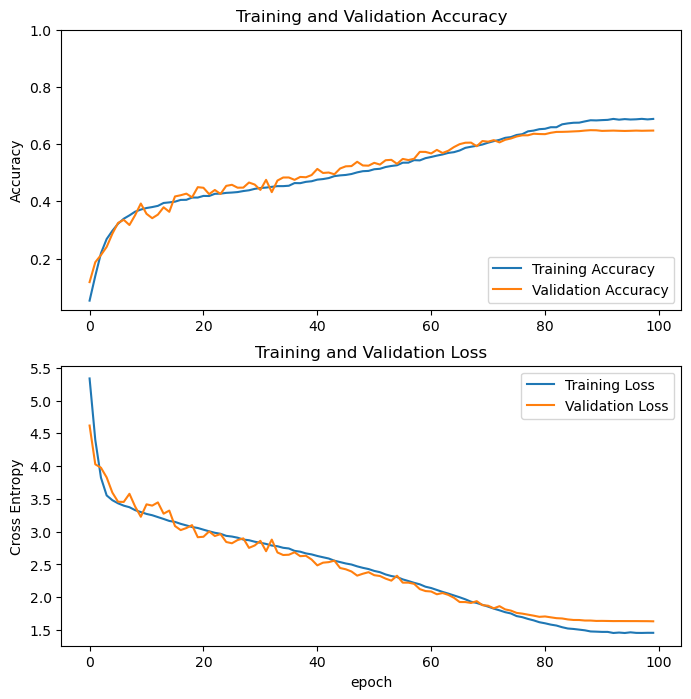

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

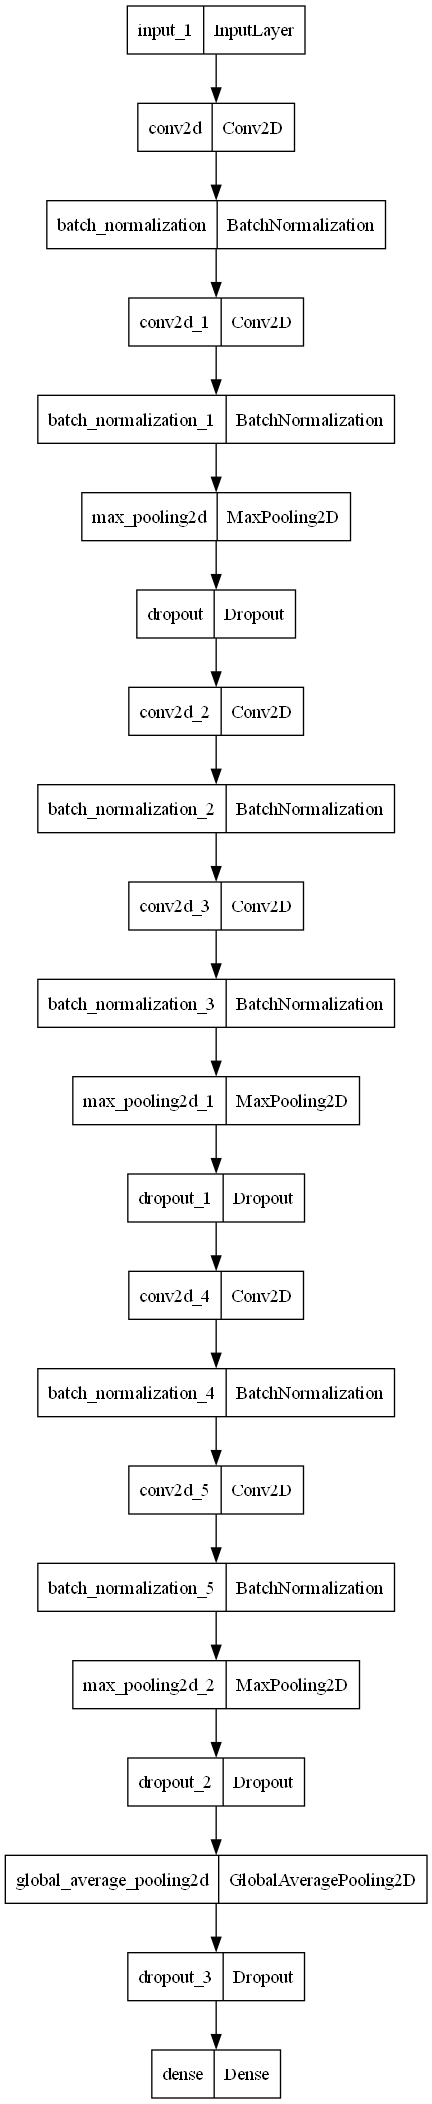

In [33]:
tf.keras.utils.plot_model(model)

In [34]:
predictions = model.predict(val_dataset)

313/313 [==============================] - 2s 7ms/step


In [35]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)
prediction_confidence = tf.reduce_max(predictions, axis=1)

In [36]:
validation_imgs = []
actual_labels = []
for imgs, labels in val_dataset:
    validation_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

validation_imgs = tf.convert_to_tensor(validation_imgs)
actual_labels = tf.convert_to_tensor(actual_labels)

In [37]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

In [ ]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 100

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

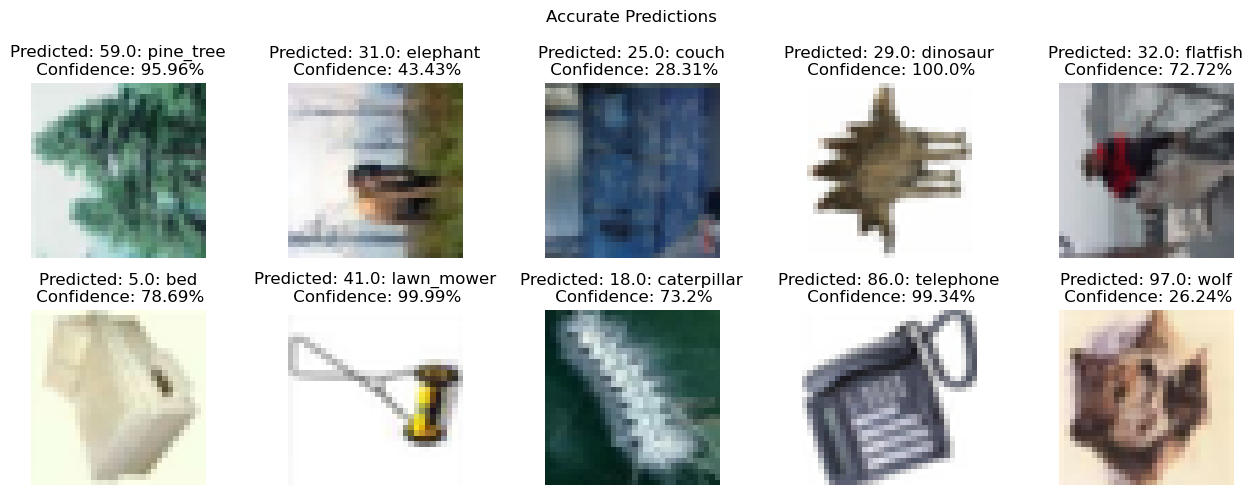

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {subclass_dict[int(predicted_labels[random_index].numpy())].decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

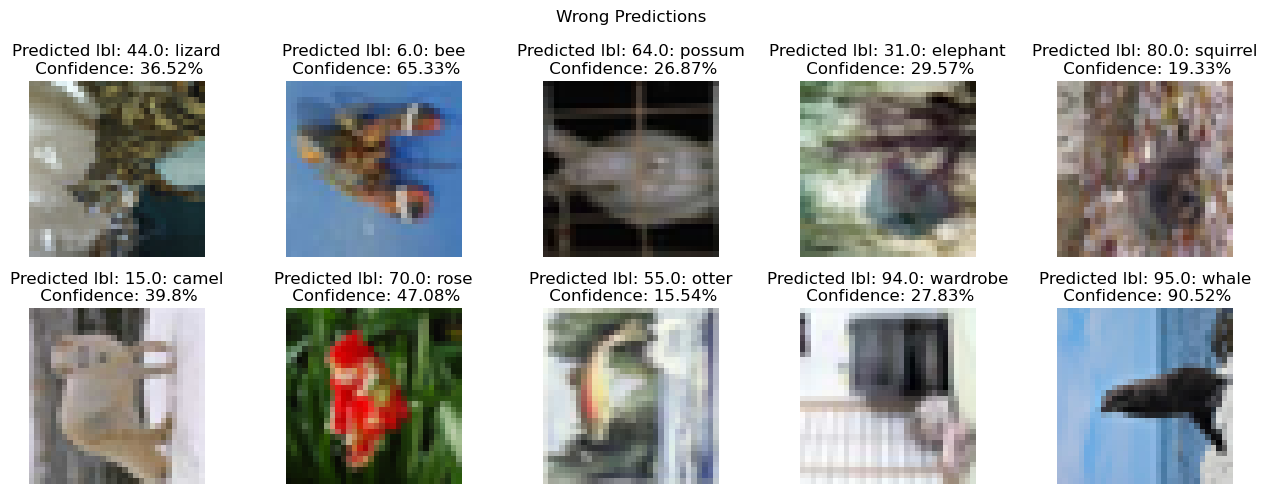

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Wrong Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels!=actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted lbl: {predicted_labels[random_index].numpy()}: {subclass_dict[int(predicted_labels[random_index].numpy())].decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### Grad-CAM

Comprehensive documentation and tutorials:

https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py

https://www.analyticsvidhya.com/blog/2023/12/grad-cam-in-deep-learning/

In [49]:
idx = np.random.randint(0, 32)
image, label = image_batch[idx], labels_batch[idx]

In [51]:
import cv2

In [52]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
        
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    
    max_val = tf.reduce_max(heatmap)
    heatmap /= max_val

    return heatmap.numpy()


In [53]:
def superimpose_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):

    if img.dtype != np.uint8:
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)

    if len(img.shape) == 3 and img.shape[2] == 3:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = img.copy()

    superimposed_img = cv2.addWeighted(heatmap_colored, alpha, img_bgr, 1 - alpha, 0)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

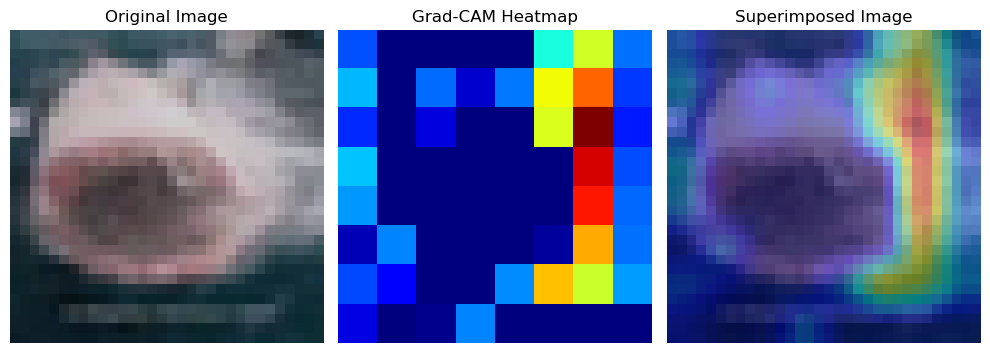

In [54]:
last_conv_layer_name = model.layers[-7].name
img = image.numpy()

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
superimposed_img = superimpose_heatmap(img, heatmap)

## Rotation 90 clockwise
img = tf.image.rot90(img, k=3)
heatmap = np.rot90(heatmap, k=3)
superimposed_img = tf.image.rot90(superimposed_img, k=3)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grad-CAM Heatmap')
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Superimposed Image')
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Transfer Learning

## Feature Extraction and Fine tuning

Great tutorial:
https://www.tensorflow.org/tutorials/images/transfer_learning

https://www.tensorflow.org/api_docs/python/tf/keras/applications/ConvNeXtBase

In [ ]:
upscale_rate = 7

In [ ]:
@tf.function
def resize_img(img, label):
    return tf.image.resize(img, (IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate)), label

In [ ]:
train_dataset_unscaled = train_dataset_unscaled.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset_unscaled = val_dataset_unscaled.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)

Note: Each Keras Application expects a specific kind of input preprocessing. For ConvNeXt, preprocessing is included in the model using a Normalization layer. ConvNeXt models expect their inputs to be float or uint8 tensors of pixels with values in the [0-255] range.

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(input_shape=(IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(.25))
model.add(tf.keras.layers.Dense(100, activation='softmax'))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
initial_epochs = 10

history_phase1 = model.fit(
    train_dataset_unscaled,
    validation_data=val_dataset_unscaled,
    epochs=initial_epochs
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 240ms/step - accuracy: 0.3128 - loss: 3.0139 - val_accuracy: 0.6019 - val_loss: 1.5089
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 234ms/step - accuracy: 0.5253 - loss: 1.7959 - val_accuracy: 0.6355 - val_loss: 1.3445
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 234ms/step - accuracy: 0.5622 - loss: 1.6302 - val_accuracy: 0.6454 - val_loss: 1.2915
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.5797 - loss: 1.5573 - val_accuracy: 0.6512 - val_loss: 1.2417
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.5935 - loss: 1.5065 - val_accuracy: 0.6532 - val_loss: 1.2282
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.5994 - loss: 1.4728 - val_accuracy: 0.6635 - val_loss: 1.2048
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.6022 - loss: 1.4506 - val_accuracy: 0.6630 - val_loss: 1.1939
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - ac

In [ ]:
base_model.trainable = True
unfreeze_last_n_layers = 50

for layer in base_model.layers[:-unfreeze_last_n_layers]:
    layer.trainable = False

In [ ]:
fine_tune_epochs = 5
initial_lr = 1e-4
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

In [ ]:
model.compile(
    optimizer=fine_tune_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_dataset_unscaled,
    validation_data=val_dataset_unscaled,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history_phase1.epoch[-1] + 1
)

Epoch 11/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 423s 314ms/step - accuracy: 0.6414 - loss: 1.2997 - val_accuracy: 0.7183 - val_loss: 0.9703
Epoch 12/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 386s 308ms/step - accuracy: 0.7117 - loss: 1.0041 - val_accuracy: 0.7330 - val_loss: 0.9114
Epoch 13/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 385s 308ms/step - accuracy: 0.7572 - loss: 0.8388 - val_accuracy: 0.7427 - val_loss: 0.8828
Epoch 14/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 385s 308ms/step - accuracy: 0.7976 - loss: 0.6871 - val_accuracy: 0.7474 - val_loss: 0.8787
Epoch 15/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 385s 308ms/step - accuracy: 0.8337 - loss: 0.5636 - val_accuracy: 0.7515 - val_loss: 0.8967


In [ ]:
acc1 = history_phase1.history['accuracy']
val_acc1 = history_phase1.history['val_accuracy']
loss1 = history_phase1.history['loss']
val_loss1 = history_phase1.history['val_loss']

acc2 = history_phase2.history['accuracy']
val_acc2 = history_phase2.history['val_accuracy']
loss2 = history_phase2.history['loss']
val_loss2 = history_phase2.history['val_loss']

In [ ]:
acc = acc1 + acc2
val_acc = val_acc1 + val_acc2
loss = loss1 + loss2
val_loss = val_loss1 + val_loss2

phase1_end = len(acc1) 

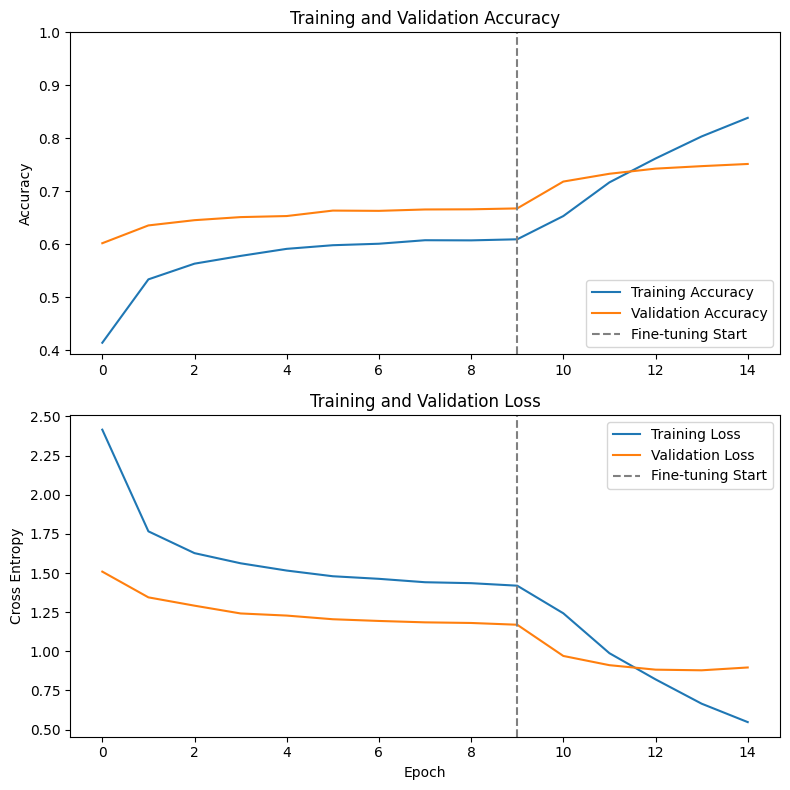

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=phase1_end - 1, color='gray', linestyle='--', label='Fine-tuning Start')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=phase1_end - 1, color='gray', linestyle='--', label='Fine-tuning Start')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

#### **Hint** : Using different Optimizer (SGD) or Learning Rate, different Augmentation (CutOut, MixUp) would enhance the Top-1 accuracy.

## Cross Validation on 3 Stratified KFold - Better Model will be tested (only)

In [ ]:
@tf.function
def resize_img(img, label):
    return tf.image.resize(img, (IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate)), label

In [ ]:
# Just for reproducibility purpose
random_splits_seeds = [43, 232, 12313]

In [ ]:
accuracies = []
initial_epochs = 10
unfreeze_last_n_layers = 50
fine_tune_epochs = 5
initial_lr = 1e-3
upscale_rate = 7

for random_state in random_splits_seeds:

    ## STRATIFIED KFOLD BASED ON RANDOM STATE
    label_train = np.array(data_train_dict[b'fine_labels'])
    train_ids, val_ids, train_labels, val_labels = train_test_split(np.arange(0, 50000), label_train, test_size=0.2, stratify=label_train, random_state=random_state)
    label_train = tf.convert_to_tensor(label_train)

    train_dataset_ids = tf.data.Dataset.from_tensor_slices(train_ids)
    val_dataset_ids = tf.data.Dataset.from_tensor_slices(val_ids)

    train_dataset_unscaled = train_dataset_ids.map(lambda id: load_img(id, with_scaling=False),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    val_dataset_unscaled = val_dataset_ids.map(lambda id: load_img(id, with_scaling=False), 
                          num_parallel_calls=tf.data.AUTOTUNE)


    train_dataset_unscaled = configure_performance(train_dataset_unscaled, is_train_ds=True, scale_mode="0_255", augmentation_type=None)
    val_dataset_unscaled = configure_performance(val_dataset_unscaled, is_train_ds=False)

    train_dataset_unscaled = train_dataset_unscaled.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset_unscaled = val_dataset_unscaled.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
    
    ## Define base model
    base_model = tf.keras.applications.ConvNeXtBase(input_shape=(IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate, 3),
                                                   include_top=False,
                                                   weights='imagenet',
                                                   include_preprocessing=True)

    base_model.trainable = False

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate, 3)))
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(.25))
    model.add(tf.keras.layers.Dense(100, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history_phase1 = model.fit(
        train_dataset_unscaled,
        validation_data=val_dataset_unscaled,
        epochs=initial_epochs
    )

    base_model.trainable = True
    
    for layer in base_model.layers[:-unfreeze_last_n_layers]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_phase2 = model.fit(
        train_dataset_unscaled,
        validation_data=val_dataset_unscaled,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=history_phase1.epoch[-1] + 1
    )
  
    
    predictions = model.predict(val_dataset_unscaled)

    predicted_labels = tf.argmax(predictions, axis=1)
    predicted_labels = tf.cast(predicted_labels, tf.float16)

    actual_labels = []

    for _, labels in val_dataset_unscaled:
        actual_labels.extend(labels.numpy())

    actual_labels = tf.convert_to_tensor(actual_labels)
    accuracy = accuracy_score(actual_labels, predicted_labels)
    print(f"Current Fold Accuracy: {round(accuracy, 4)}")
    accuracies.append(accuracy)    
    del val_dataset_unscaled, base_model, model
    K.clear_session()


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 366s 258ms/step - accuracy: 0.3138 - loss: 3.0032 - val_accuracy: 0.5987 - val_loss: 1.4979
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.5233 - loss: 1.8119 - val_accuracy: 0.6327 - val_loss: 1.3290
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 234ms/step - accuracy: 0.5588 - loss: 1.6646 - val_accuracy: 0.6440 - val_loss: 1.2760
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.5750 - loss: 1.5667 - val_accuracy: 0.6603 - val_loss: 1.2293
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 234ms/step - accuracy: 0.5871 - loss: 1.5286 - val_accuracy: 0.6568 - val_loss: 1.2162
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.5949 - loss: 1.4817 - val_accuracy: 0.6615 - val_loss: 1.1880
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 234ms/step - accuracy: 0.6006 - loss: 1.4574 - val_accuracy: 0.6705 - val_loss: 1.1785
Epoch 8/1

In [1]:
print(f"3 Fold avg. accuracy: {round(np.mean(accuracies)*100, 2)}%")
print(f"3 Fold std: {round(np.std(accuracies)*100, 2)}%")

3 Fold avg. accuracy: 75.31%
3 Fold std: 0.6%


## Prediction on the Test set

In [ ]:
data_train = tf.convert_to_tensor(data_train)
label_train = tf.convert_to_tensor(label_train)
data_test = tf.convert_to_tensor(data_test)
label_test = tf.convert_to_tensor(label_test)

In [ ]:
train_ids = np.arange(0, 50000)
test_ids = np.arange(0, 10000)

In [ ]:
train_dataset_ids = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset_unscaled = train_dataset_ids.map(lambda id: load_img(id, with_scaling=False),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [ ]:
test_dataset_ids = tf.data.Dataset.from_tensor_slices(test_ids)
test_dataset_unscaled = test_dataset_ids.map(lambda id: load_img(id, with_scaling=False),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [ ]:
train_dataset_unscaled = configure_performance(train_dataset_unscaled, is_train_ds=True, scale_mode="0_255", augmentation_type=None)
test_dataset_unscaled = configure_performance(test_dataset_unscaled, is_train_ds=False)

In [ ]:
upscale_rate = 7
train_dataset_unscaled = train_dataset_unscaled.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_unscaled = test_dataset_unscaled.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(input_shape=(IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT * upscale_rate, IMG_WIDTH * upscale_rate, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(.25))
model.add(tf.keras.layers.Dense(100, activation='softmax'))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
initial_epochs = 10

history_phase1 = model.fit(
    train_dataset_unscaled,
#    validation_data=test_dataset_unscaled, ## simulate a real-word scenario
    epochs=initial_epochs
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 323s 192ms/step - accuracy: 0.3401 - loss: 2.8627
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 296s 189ms/step - accuracy: 0.5373 - loss: 1.7588
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 296s 189ms/step - accuracy: 0.5619 - loss: 1.6268
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 296s 189ms/step - accuracy: 0.5774 - loss: 1.5544
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 296s 189ms/step - accuracy: 0.5858 - loss: 1.5198
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 189ms/step - accuracy: 0.5954 - loss: 1.4903
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 189ms/step - accuracy: 0.5992 - loss: 1.4665
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 189ms/step - accuracy: 0.6014 - loss: 1.4579
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 189ms/step - accuracy: 0.6042 - loss: 1.4412
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 189ms/step - accuracy: 0.6056 - loss: 1.4449


In [ ]:
base_model.trainable = True
unfreeze_last_n_layers = 50

for layer in base_model.layers[:-unfreeze_last_n_layers]:
    layer.trainable = False

In [ ]:
fine_tune_epochs = 5
initial_lr = 1e-4
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

In [ ]:
model.compile(
    optimizer=fine_tune_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_dataset_unscaled,
#    validation_data=val_dataset_unscaled,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history_phase1.epoch[-1] + 1
)

Epoch 11/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 453s 269ms/step - accuracy: 0.6362 - loss: 1.3220
Epoch 12/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 410s 262ms/step - accuracy: 0.7111 - loss: 1.0061
Epoch 13/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 409s 262ms/step - accuracy: 0.7617 - loss: 0.8168
Epoch 14/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 409s 262ms/step - accuracy: 0.8018 - loss: 0.6704
Epoch 15/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 409s 262ms/step - accuracy: 0.8387 - loss: 0.5465


In [ ]:
predictions = model.predict(test_dataset_unscaled)

predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)
prediction_confidence = tf.reduce_max(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step


In [ ]:
test_imgs = []
actual_labels = []
for imgs, labels in test_dataset_unscaled:
    test_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

test_imgs = tf.convert_to_tensor(test_imgs)
actual_labels = tf.convert_to_tensor(actual_labels)

In [ ]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

In [ ]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")


Macro-average F1-score: 0.9096


In [ ]:
print(f"Mean Interclass Precision: {np.round(np.mean(precision), 4)}")
print(f"Mean Interclass Recall: {np.round(np.mean(recall), 4)}")
print(f"Top-1 Accuracy: {accuracy}")

Mean Interclass Precision: 0.9122
Mean Interclass Recall: 0.9109
Top-1 Accuracy: 0.9104


In [ ]:
test_imgs = tf.cast(test_imgs, "uint8")

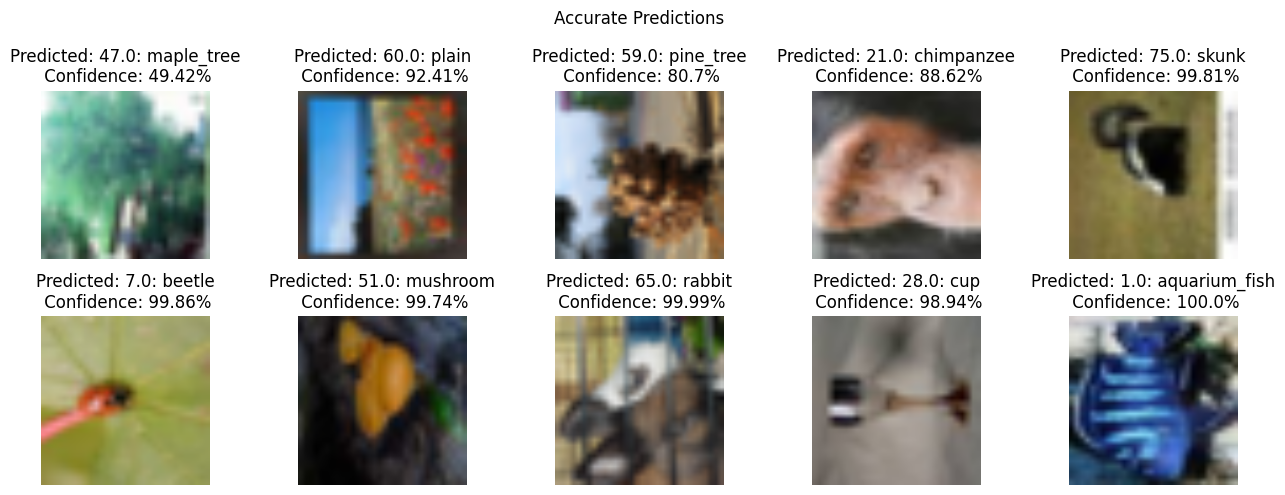

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = test_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {subclass_dict[int(predicted_labels[random_index].numpy())].decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

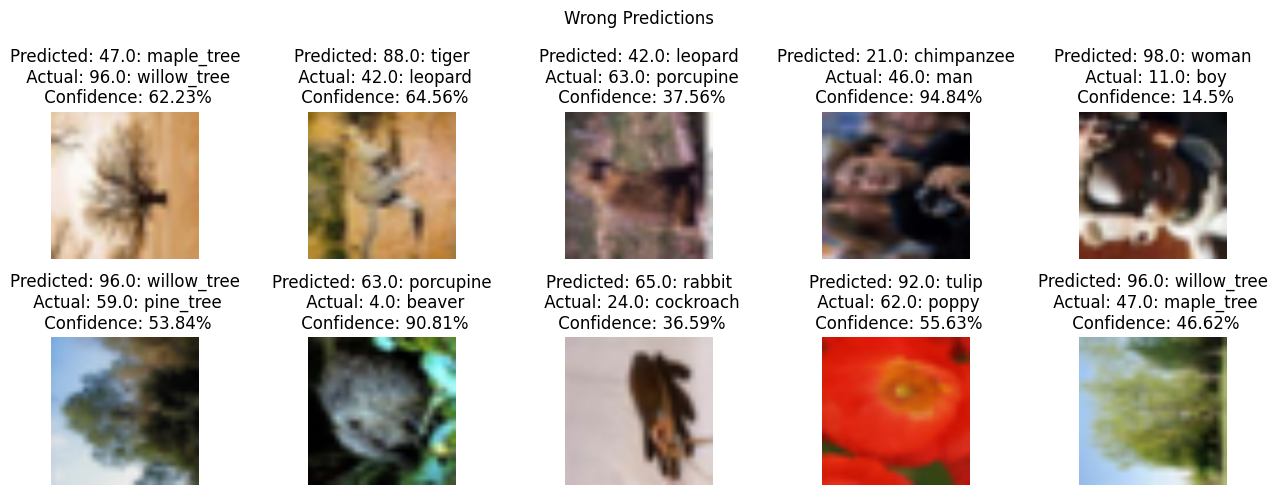

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Wrong Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels!=actual_labels)[0])
    image = test_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {subclass_dict[int(predicted_labels[random_index].numpy())].decode('utf8')}\n Actual: {actual_labels[random_index]}: {subclass_dict[int(actual_labels[random_index].numpy())].decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()